# Предсказание оттока клиентов 

In [1]:
import warnings
warnings.simplefilter("ignore")

#Импортируем библиотеки для анализа
import pandas as pd
import numpy as np

#Импортируем библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import cross_val_score


In [2]:
from catboost import CatBoostClassifier

In [3]:
train_df = pd.read_csv('../input/advanced-dls-fall-2020/train.csv')
test_df = pd.read_csv('../input/advanced-dls-fall-2020/test.csv')

train_df

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
0,55,19.50,1026.35,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,0
1,72,25.85,1872.2,Male,0,Yes,No,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),0
2,1,75.90,75.9,Male,0,No,No,Yes,No,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check,1
3,32,79.30,2570,Female,1,Yes,No,Yes,Yes,Fiber optic,No,No,Yes,No,No,No,Month-to-month,No,Mailed check,0
4,60,115.25,6758.45,Female,0,Yes,Yes,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,No,Credit card (automatic),0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5277,3,30.40,82.15,Male,0,No,No,No,No phone service,DSL,No,No,No,Yes,No,No,Month-to-month,No,Electronic check,0
5278,50,44.45,2188.45,Male,0,Yes,No,No,No phone service,DSL,Yes,No,No,Yes,Yes,No,One year,Yes,Bank transfer (automatic),0
5279,1,55.05,55.05,Male,0,No,No,Yes,No,DSL,No,No,Yes,Yes,No,No,Month-to-month,No,Mailed check,0
5280,29,76.00,2215.25,Female,0,No,No,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Credit card (automatic),0


In [4]:
train_df['TotalSpent'] = train_df['TotalSpent'].apply(pd.to_numeric, errors='coerce')
test_df['TotalSpent'] = test_df['TotalSpent'].apply(pd.to_numeric, errors='coerce')

In [5]:
train_df.isna().sum()

ClientPeriod                0
MonthlySpending             0
TotalSpent                  9
Sex                         0
IsSeniorCitizen             0
HasPartner                  0
HasChild                    0
HasPhoneService             0
HasMultiplePhoneNumbers     0
HasInternetService          0
HasOnlineSecurityService    0
HasOnlineBackup             0
HasDeviceProtection         0
HasTechSupportAccess        0
HasOnlineTV                 0
HasMovieSubscription        0
HasContractPhone            0
IsBillingPaperless          0
PaymentMethod               0
Churn                       0
dtype: int64

Заменим на ноль пропущенные значения, которые возникают в связи с тем, что они возникают у клиентов которые имеют ноль периодов 

In [6]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(np.nan,'constant')
train_df['TotalSpent'] = imputer.fit_transform(np.array(train_df[['TotalSpent']]))
test_df['TotalSpent'] = imputer.fit_transform(np.array(test_df[['TotalSpent']]))

In [7]:
train_df['ClientPeriod/MonthlySpending'] = train_df['ClientPeriod'] / train_df['MonthlySpending']
test_df['ClientPeriod/MonthlySpending'] = test_df['ClientPeriod'] / test_df['MonthlySpending']
train_df['MonthlySpending/ClientPeriod'] = train_df['MonthlySpending'] / train_df['ClientPeriod']
test_df['MonthlySpending/ClientPeriod'] = test_df['MonthlySpending'] / test_df['ClientPeriod']
train_df['MonthlySpending/ClientPeriod'] = train_df['MonthlySpending/ClientPeriod'].replace([-np.inf, np.inf], [0, 0])
test_df['MonthlySpending/ClientPeriod'] = test_df['MonthlySpending/ClientPeriod'].replace([-np.inf, np.inf], [0, 0])

## Визуализируем данные

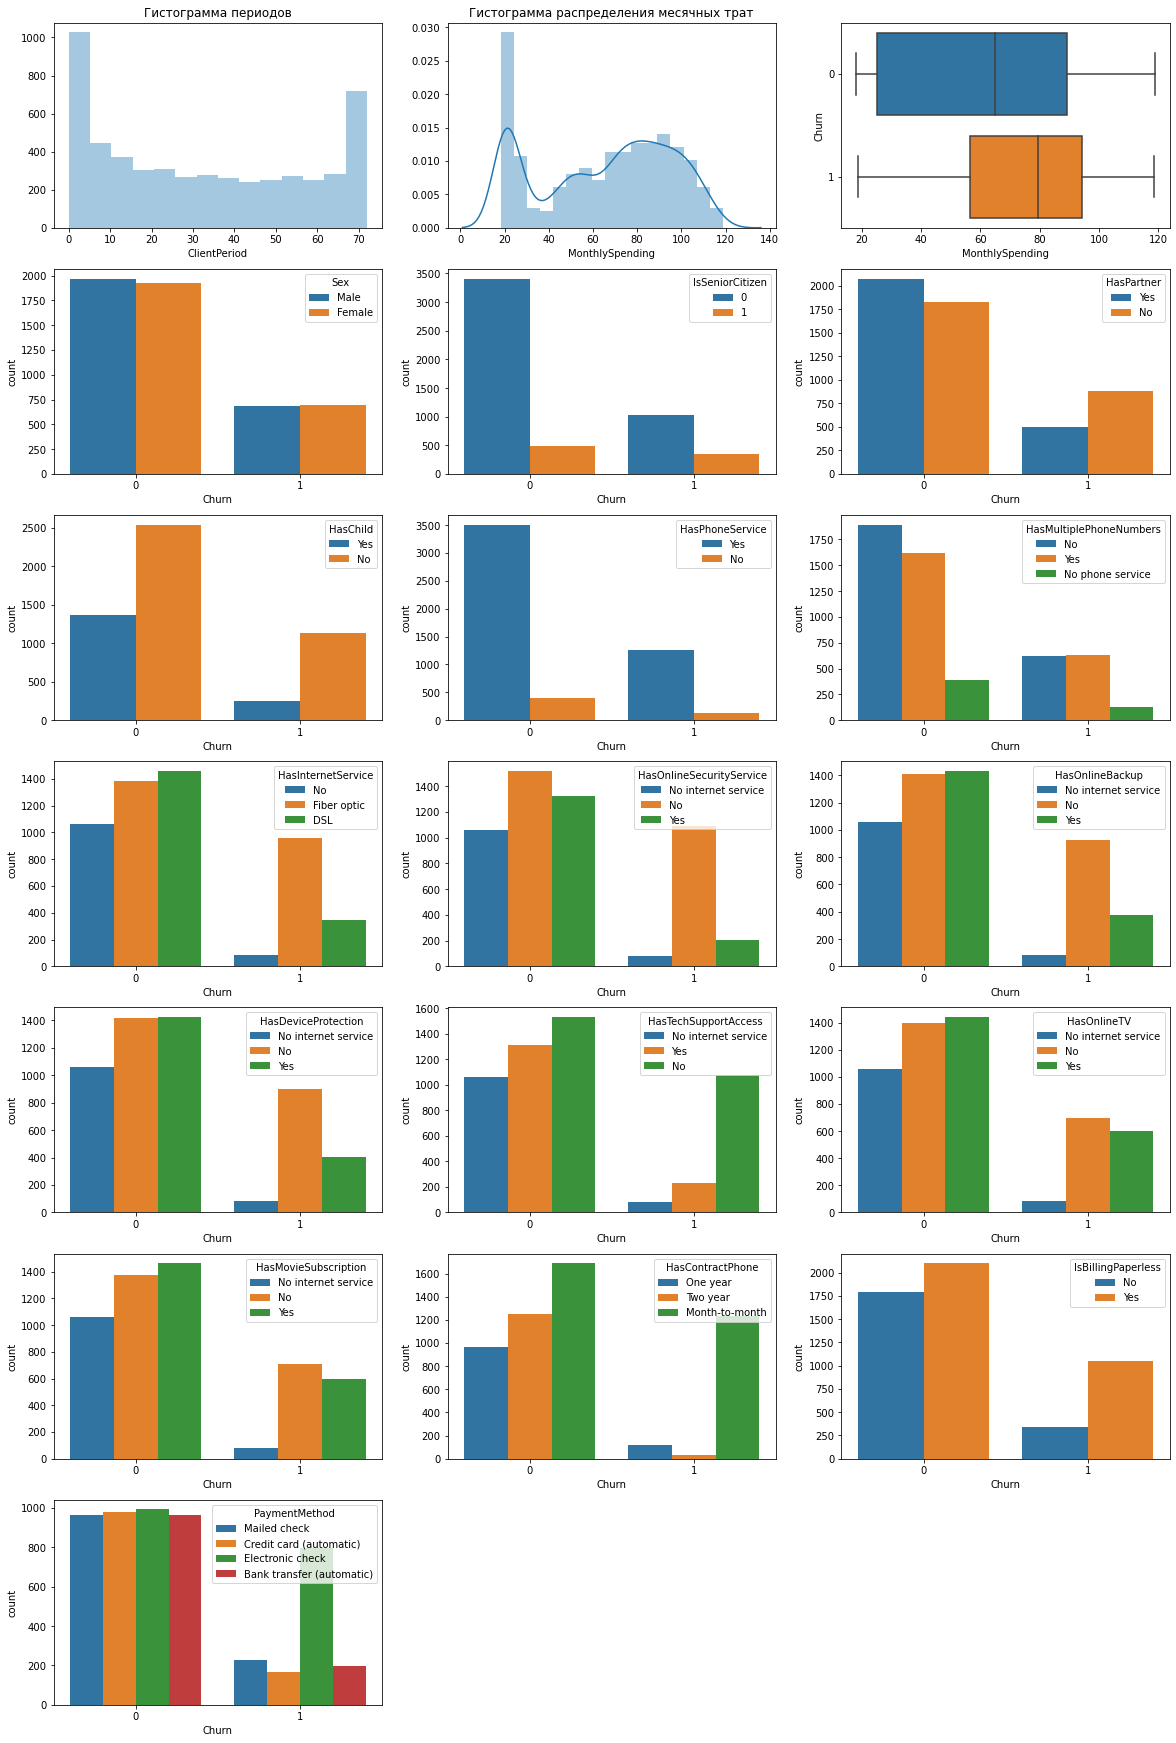

In [8]:
fig = plt.figure(figsize=(20,40))

ax_1 = fig.add_subplot(9, 3, 1)
ax_1 = sns.distplot(train_df["ClientPeriod"], kde = False )
ax_1 = plt.title('Гистограмма периодов')
ax_2 = fig.add_subplot(9, 3, 2)
ax_2 = sns.distplot(train_df["MonthlySpending"], kde = True )
ax_2 = plt.title('Гистограмма распределения месячных трат')
ax_3 = fig.add_subplot(9, 3, 3)
sns.boxplot(x = train_df["MonthlySpending"],y =train_df["Churn"] , orient = "h")
ax_4 = fig.add_subplot(9, 3, 4)
sns.countplot(x='Churn', hue='Sex', data=train_df)
ax_5 = fig.add_subplot(9, 3, 5)
sns.countplot(x='Churn', hue='IsSeniorCitizen', data=train_df)
ax_6 = fig.add_subplot(9, 3, 6)
sns.countplot(x='Churn', hue='HasPartner', data=train_df)
ax_7 = fig.add_subplot(9, 3, 7)
sns.countplot(x='Churn', hue='HasChild', data=train_df)
ax_8 = fig.add_subplot(9, 3, 8)
sns.countplot(x='Churn', hue='HasPhoneService', data=train_df)
ax_9 = fig.add_subplot(9, 3, 9)
sns.countplot(x='Churn', hue='HasMultiplePhoneNumbers', data=train_df)
ax_10 = fig.add_subplot(9, 3, 10)
sns.countplot(x='Churn', hue='HasInternetService', data=train_df)
ax_11 = fig.add_subplot(9, 3, 11)
sns.countplot(x='Churn', hue='HasOnlineSecurityService', data=train_df)
ax_12 = fig.add_subplot(9, 3, 12)
sns.countplot(x='Churn', hue='HasOnlineBackup', data=train_df)
ax_13 = fig.add_subplot(9, 3, 13)
sns.countplot(x='Churn', hue='HasDeviceProtection', data=train_df)
ax_14 = fig.add_subplot(9, 3, 14)
sns.countplot(x='Churn', hue='HasTechSupportAccess', data=train_df)
ax_15 = fig.add_subplot(9, 3, 15)
sns.countplot(x='Churn', hue='HasOnlineTV', data=train_df)
ax_16 = fig.add_subplot(9, 3, 16)
sns.countplot(x='Churn', hue='HasMovieSubscription', data=train_df)
ax_17 = fig.add_subplot(9, 3, 17)
sns.countplot(x='Churn', hue='HasContractPhone', data=train_df)
ax_18 = fig.add_subplot(9, 3, 18)
sns.countplot(x='Churn', hue='IsBillingPaperless', data=train_df)
ax_19 = fig.add_subplot(9, 3, 19)
sns.countplot(x='Churn', hue='PaymentMethod', data=train_df)
plt.show()

In [9]:
X= train_df.drop(['Churn'], 1)
y= train_df['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [10]:
cat = ['HasMultiplePhoneNumbers','HasInternetService','HasOnlineSecurityService','HasOnlineBackup','HasDeviceProtection','HasTechSupportAccess','HasOnlineTV','HasMovieSubscription','HasContractPhone','PaymentMethod']

integer = ['MonthlySpending','TotalSpent','ClientPeriod/MonthlySpending','MonthlySpending/ClientPeriod']

In [11]:
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

data_transformer = ColumnTransformer(
    transformers=[
        ('numerical', numerical_transformer, integer),
        ('categorical', categorical_transformer, cat)])

preprocessor = Pipeline(steps=[('data_transformer', data_transformer)])


In [12]:
cols = ["Classifier", "Accuracy"]
df = pd.DataFrame(columns=cols)

dicti = {}

classifiers = [
    KNeighborsClassifier(3),
    SVC(probability=True),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis(),
    LogisticRegression(C = 0.35938137)]

for clf in classifiers:
    classifier = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', clf)])
    cv_results = cross_val_score(classifier, X_train, y_train, scoring="roc_auc", cv=3)
    res = np.mean(cv_results)
    name =clf.__class__.__name__
    dicti[name] = res
    
    
classifier = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', xgb.XGBClassifier(objective='binary:logistic', seed=0))])                  
cv_results = cross_val_score(classifier, X_train, y_train, scoring="roc_auc", cv=3)
dicti['XGBClassifier'] = np.mean(cv_results)

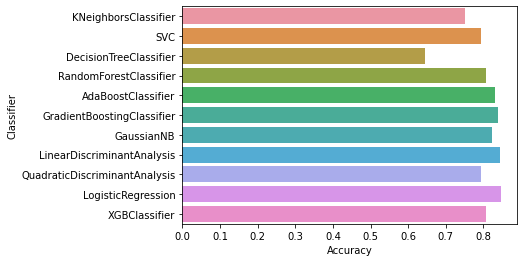

In [13]:
for clf in dicti:
    dfe = pd.DataFrame([[clf, dicti[clf]]], columns=cols)
    df = df.append(dfe)
    
sns.barplot(x='Accuracy', y='Classifier', data=df)
plt.show()

Логистическая регрессия при настройке параметров позволяет добитаться точности 0.85 ROC-AUC score
В свою очередь использование catboost позволяет поднять результат выше 0.85 

In [14]:
categorical_features = ['Sex', 'IsSeniorCitizen','HasPartner', 'HasChild', 'HasPhoneService',
       'HasMultiplePhoneNumbers', 'HasInternetService',
       'HasOnlineSecurityService', 'HasOnlineBackup', 'HasDeviceProtection',
       'HasTechSupportAccess', 'HasOnlineTV', 'HasMovieSubscription',
       'HasContractPhone', 'IsBillingPaperless', 'PaymentMethod']

In [15]:
model = CatBoostClassifier(depth = 6, loss_function = 'Logloss',bootstrap_type = 'MVS', iterations = 300,l2_leaf_reg = 0.864406779661017, cat_features =categorical_features,  eval_metric = 'AUC',verbose=False)

In [16]:
model.fit(X_train,y_train)
pred =model.predict_proba(X_test)
print(roc_auc_score(y_test,pred[:,1]))


0.8369067037065354


Пока данные настройки модели дают скор на тестовых данных в кэгл 0.85357
	